We have three methods to find the Gradient of a loss function but we generally use First Order Gradient method but we shall dive into some adavanced methods like AdaGradient and Newton's method of second order Taylor expansion approximation.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.preprocessing import StandardScaler
data=pd.read_csv('./Datasets ML/diabetes-regression/diabetes-data.csv',names=[f'feature {num}' for num in range(11)])
sc=StandardScaler()
data=sc.fit_transform(data)

x=data[:,0:-1]
y=data[:,-1].reshape(-1,1)

### Gradient descent First order method

In [3]:
def loss(w,x,y):
    residue=y-x.dot(w)
    loss=np.square(residue)
    return residue,np.sum(loss)   

def efficacy(w,x,y):
    y_hat=x.dot(w[0:-1])+w[0][-1]
    res=np.sum(np.square(y-y_hat))
    mean=np.sum(np.square(y-np.mean(y)))
    print('Accuracy: ',1-(res/mean))

In [4]:
def gradient_descent(x,y,max_iter=100,alpha=0.0001,delta=0.1):
    x=np.append(x,np.ones((x.shape[0],1)),axis=1)
    w=np.zeros((x.shape[1],1))
    losses=[]
    wt=np.zeros((x.shape[1],1))
    cond=True
    itera=0
    
    while(cond):
        r,l=loss(w,x,y)
        losses.append(l)
        gd=(-2*r.T).dot(x)
        s=-alpha*gd
        if (np.abs(np.sum(gd))<delta) or (itera>max_iter):
            break
        w+=s.reshape(-1,1)
        wt=np.append(wt,w,axis=1)
        itera+=1
    
    print('Converged at: ',itera)
    return w,losses,wt

In [5]:
model=gradient_descent(x,y)
efficacy(model[0],x,y)

Converged at:  49
Accuracy:  0.5140472121596577


### Visualization of steps

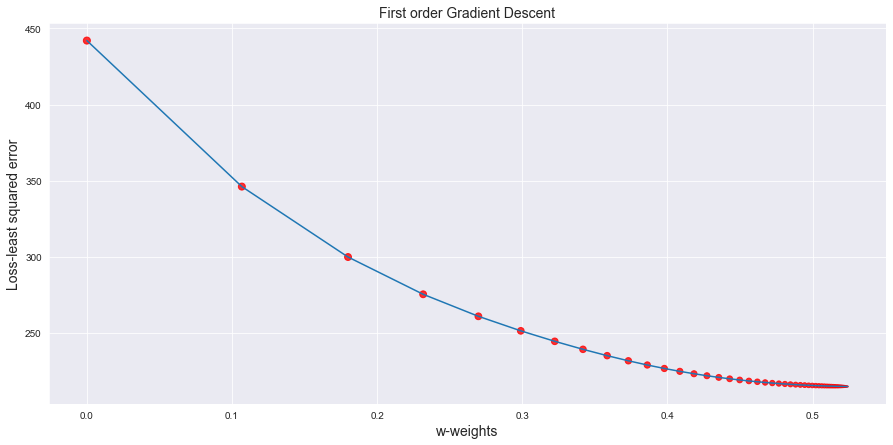

In [6]:
def plot(model,title):
    w=np.linalg.norm(model[2],axis=0)
    losses=model[1]
    plt.figure(figsize=(15,7))
    sns.set_style('darkgrid')
    plt.scatter(w,losses,color='r',s=[50-i for i in range(0,len(w))],alpha=0.8)
    plt.plot(w,losses)
    plt.title(title,fontsize=14)
    plt.xlabel('w-weights',fontsize=14)
    plt.ylabel('Loss-least squared error',fontsize=14)
    plt.show()
plot(model,'First order Gradient Descent')

### Comparing Efficiency with sklearn model

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
model_2=LinearRegression()
model_2.fit(x,y)
score_2=r2_score(y,model_2.predict(x))
print('Accuracy of sklearn closed form solution: ', score_2)

Accuracy of sklearn closed form solution:  0.5177484222203499


When it comes to step size. We initialize a constant and its value goes on decreasing as iterations or steps increase.<br>
One of the method is "Exponential decay". Step size decrease exponentially.<br>
Second is "Inverse time decay". Step size is inversely proportional to steps.<br>
Next is "Ada-Grad".<br>

#### Ada-Gradient

In Adaptive Gradient technique step size is automatically according to the gradient.<br>

In [8]:
w0=np.zeros(shape=(x.shape[1]+1,1))
x_ada=np.append(x,np.ones((x.shape[0],1)),axis=1)
initial_rate=0.1
delta=0.1
itera=0
z=0
max_iter=2000
while(True):  
    r,l=loss(w0,x_ada,y)
    dl=(-2*r.T.dot(x_ada))[0]
    z+=dl**2
    alpha=initial_rate/(np.sqrt(z+0.001))
    
    if (itera>max_iter) or np.linalg.norm(dl)<delta :
        break
        
    s=(-2*alpha*dl).reshape(-1,1)
    w0=w0+s
    itera+=1
print('Converged at: ',itera)
efficacy(w0,x,y)

Converged at:  1505
Accuracy:  0.5177092460657893


Thus we had a better efficiency while using AdaGrad technique for optimizing step size.(almost equal to sklearn)

### Newton's method in Gradient descent

In this we are using tensorflow instead of classic modules for programming.

In [9]:
def gradient(w0,x_data,y_data):
    with tf.GradientTape() as tape2:
        tape2.watch(w0)
        loss=tf.reduce_sum(tf.square(y_data-tf.matmul(x_data,w0)))
    dl=tape2.gradient(loss,w0)
    return dl

def hessian(w,x,y):
    n=w.shape[0]
    H=tf.Variable(tf.zeros((n,n),'float64'),name="Hessian")
    for i in range(0,n):
        for j in range(0,n):
            H[i,j].assign(2*tf.reduce_sum(x[:,i]*x[:,j]))
    return H

In [10]:
def Newtons(w,x_data,y_data,max_iter=100,delta=0.1):
    wt=tf.Variable(tf.zeros(shape=(x_data.shape[1],1),dtype='float64'),'Weights Record')
    itera=0
    losses=[]
    losses.append(loss(w.numpy(),x_data.numpy(),y_data.numpy())[1])
    
    while(True):
        H=hessian(w,x_data,y_data)
        g=gradient(w,x_data,y_data)
        H_inv=tf.linalg.inv(H)
        
        if (tf.norm(g)<delta) or (itera>max_iter):
            break
        itera+=1
        s=tf.matmul(-H_inv,g)
        w.assign(w+s)
        
        l=loss(w.numpy(),x_data.numpy(),y_data.numpy())[1]
        losses.append(l)
        wt=tf.concat((wt,w),axis=1)
        
    print('Converged at: ',itera)
    return w,losses,wt            

In [12]:
x_data=tf.constant(x_ada)
y_data=tf.constant(y,shape=(len(y),1))
w=tf.Variable(tf.zeros(shape=(x_data.shape[1],1),dtype='float64'),'Weights')
model_3=Newtons(w,x_data,y_data)
efficacy(model_3[0].numpy(),x,y)

Converged at:  1
Accuracy:  0.51771019365319


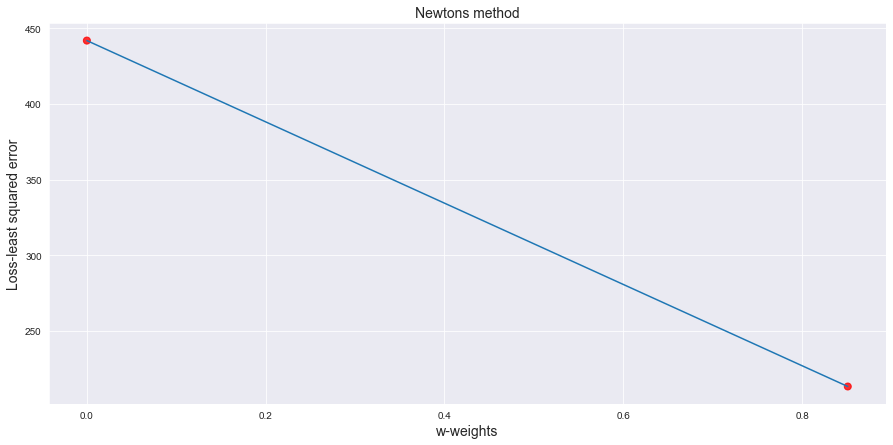

In [13]:
plot(model_3,'Newtons method')

### Combining Both the plots we have

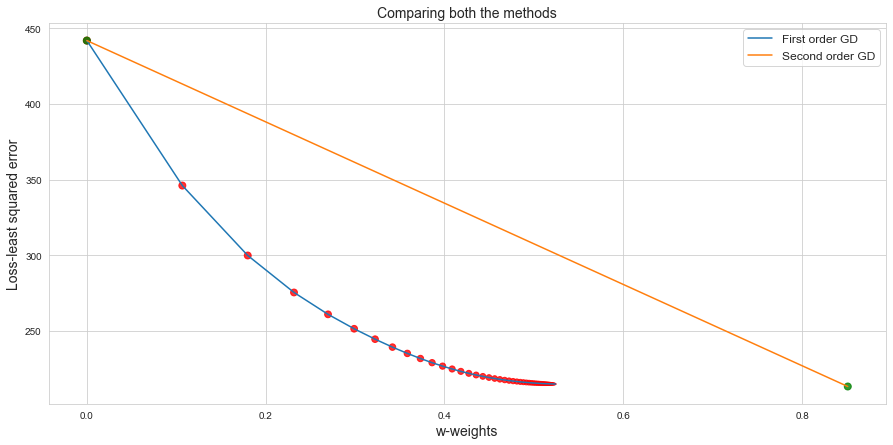

In [14]:
w1=np.linalg.norm(model[2],axis=0)
w2=np.linalg.norm(model_3[2],axis=0)
losses1=model[1]
losses2=model_3[1]
plt.figure(figsize=(15,7))
sns.set_style('whitegrid')
plt.scatter(w1,losses1,color='r',s=[50-i for i in range(0,len(w1))],alpha=0.8)
plt.plot(w1,losses1)
plt.scatter(w2,losses2,color='g',s=[50-i for i in range(0,len(w2))],alpha=0.8)
plt.plot(w2,losses2)
plt.title('Comparing both the methods',fontsize=14)
plt.xlabel('w-weights',fontsize=14)
plt.ylabel('Loss-least squared error',fontsize=14)
plt.legend(['First order GD','Second order GD'],fontsize=12)
plt.show()

Thus the best practice is to use First order in a couple of steps and then use a few iterations of Second order Gradient Descent as the First order takes forewer to converge when gradient is small. Although Second order is computationally high so should be used in few iterations. 